# Analyze A/B Test Results for an e-Commerce Website

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Conclusion](#conclusion)


<a id='intro'></a>
### Introduction

**A/B tests** are very commonly performed by data analysts and data scientists. It is commonwly used to test changes on a web page by running experiment(s) where a control group sees the old page, while the treatment (experiment) group sees the new page. A metric is chosen to measure the level of engagement from users in each group. The results is used to judge whether one version is more effective than the other.<br>

In this project, I analysed the data to understand the results of an A/B test run by an e-commerce website. The *conversion* or *conversion rate* was chosen as the metric for this analysis. The **goal** is:
> *to conduct experiment(s) and analyse data to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.*

### Analysis Approach
This analysis was done systematically using 7-step approach.
1. **Understand the datasets**: I reviewed the variables in the datasets
2. **State Hypothesis:** Given the goal of this analysis, I stated the null and alternate hypothesis
3. **Perform Wrangling:** I read in the data from CSV, assessed and cleaned data set using *pandas* and *numpy* libraries in *Python*
4. **Conduct Exploratory Data Analysis (EDA):** Explored the data and created visuals to get clarity of the dataset and maximise the potential of the analysis.*pandas*, *numpy* and *matplotlib* libraries in *Python*. This step was done concurrently with wrangling.
5. **Test Hypothesis**: I performed A/B testing (using both the walk-through and built-in method) leveraging *pandas*, *numpy*, *ramdom* and *statsmodels.api*. I also conducted a regression analysis to confirm the result from A/B testing
4. **Draw Conclusions:** Intepreted the result from the descriptive and inferential statistical analysis done.
5. **Communicate:** Communicated insights in this *Jupyter Notebook*.

In [1]:
#Import libraries
import pandas as pd
import numpy as np
import random
import statsmodels.api as sms
import matplotlib.pyplot as plt
%matplotlib inline

#set seed to assure that the same answers is gotten each time
random.seed(42)

<a id='probability'></a>
#### Part I - Probability

##### `1.` Read in the `ab_data.csv` data and store it in `df`

In [2]:
#a. Take a look at the top 5 rows
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [3]:
#b. Find number of rows in the dataset
df.shape[0] 

294478

In [4]:
#c. The number of unique users in the dataset
df['user_id'].nunique() 

#Given that this is less than the number of rows,
#it signify duplicate users within the datasets that will be addressed later

290584

d. The proportion of users converted.

In [5]:
#d. The proportion of users converted
df['converted'].mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.
>This match is necessary as treatment group are meant to *land* on the new page in this experiment while control group should *land* on the old page.

In [6]:
#This should be 0. Values != 0 should be noted for cleaning
df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False].shape[0]

3893

In [7]:
#f. Check for missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


##### `2.` Drop rows with mismatch in `group` and `landing_page` and store it in `df2`

These are rows where:
1. **treatment** does not match with **new_page** or
2. **control** does not match with **old_page**
As one cannot be sure if these rows truly received the new or old page.<br>
a. Create a new dataset that meets the specifications and store dataframe in df2.

In [8]:
#drop rows where `treatment` does not match with `new_page`
df1 = df.drop(df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page'
                                    )) == False].index)

In [9]:
#Double Check all of the correct rows were removed - this should be 0
df1[((df1['group'] == 'treatment') == (df1['landing_page'] == 'new_page'
                                    )) == False].shape[0]

0

In [10]:
#df.query('group == "treatment" and landing_page == "old_page"')['group'].count() + df.query('group == "control" and landing_page != "old_page"')['group'].count()

In [11]:
# Drop rows where control does not match with old_page
df2 = df1.drop(df1[(df1['group'] == 'control') & (df1['landing_page'] == 'new_page')].index)


In [12]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'control') == (df2['landing_page'] == 'old_page')) == False].shape[0]

0

In [13]:
#Note new sample size
df2.count()

user_id         290585
timestamp       290585
group           290585
landing_page    290585
converted       290585
dtype: int64

##### `3.` Remove row(s) with duplicate `user_id`  in `df2`

Presence of duplicate is indicated by the data showing that count for columns is `290,585` while unique_id is `290,584`

In [14]:
#a. Check unique user_ids are in df2
df2['user_id'].nunique()

290584

In [15]:
#b. Check for the one user_id repeated in df2
df2[df2.duplicated(subset=['user_id'], keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [16]:
#Row information for the repeated user_id
df2[df2.duplicated(subset=['user_id'], keep='first')]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [17]:
#Remove one of the rows with duplicate user_id and keep dataframe as df2
df2 = df2.drop_duplicates(subset=['user_id'], keep='first')

In [18]:
#Double check
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290584 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       290584 non-null  int64 
 1   timestamp     290584 non-null  object
 2   group         290584 non-null  object
 3   landing_page  290584 non-null  object
 4   converted     290584 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 13.3+ MB


##### `4.` Using `df2`, calculate probability


In [19]:
#a. Probability of an individual converting regardless of the page they receive
df2['converted'].mean()

0.11959708724499628

In [20]:
#b. Probability of conversion in control group
control = df2.group == 'control'
df2.converted[control].mean()

0.1203863045004612

In [21]:
#c. Probability of conversion in treatment group
treatment = df2.group == 'treatment'
df2.converted[treatment].mean()

0.11880806551510564

In [22]:
#d. Probability that an individual received the new page
df2['landing_page'][df2['landing_page'] == 'new_page'].count()/df2.shape[0]

0.5000619442226688

**Conclusion based on a. through d. above (Probability)**

> **Probability of conversion is 0.119 and 0.120 in the `treatment` and `control` group, respectively. This difference of -0.001 (`treatment` - `control`) is no sufficient evidence to suggest that the new treatment page leads to more conversions.**<br>
> Although the sample size seems large enough (>100,000 in each group), one might need to assess the following:
> - The duration of experiment- was it run long enough to cover for change aversion and novelty effect.
> - The type of participants- if it was new or old clients and the prportion of each in bith groups (treatment and control).

<a id='ab_test'></a>
### Part II - A/B Test

`1.` Analyse A/B Test Results to make decision based on all the data provided.

**Null and Alternative Hypothesis**

$$H_0: p_{new} - p_{old} <= 0$$

$$H_0: p_{new} - p_{old} > 0$$

$$\alpha = 0.05$$


>$p_{new}$ and $p_{old}$ are the population converted rates for the new and old pages, respectively.<br><br>
$\alpha$ is the Type I error rate

`2.` It was assumed under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, it was assumed that they are equal to the **converted** rate in **ab_data.csv** regardless of the page. A sample size for each page equal to the ones in **ab_data.csv** was used.  <br>
Subsequently, the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null was performed.  <br>

a. **Conversion rate** for $p_{new}$ under the null

In [23]:
cv_new = df2['converted'].mean()
cv_new

0.11959708724499628

b. **Conversion rate** for $p_{old}$ under the null

In [24]:
df2['converted'].mean()

0.11959708724499628

c. $n_{new}$ - the number of individuals in the **treatment** group

In [25]:
number_new = df2[treatment]['user_id'].count()
number_new

145310

d. $n_{old}$- the number of individuals in the **control** group

In [26]:
df2[control]['user_id'].count()

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

> **I noticed that in both cases, the mean changed whenever I ran it...is this normal?**

In [27]:
new_page_converted = np.random.choice([0,1], size = (number_new,1), p = [(1-cv_new), cv_new])

In [28]:
new_page_converted.mean()

0.11920033032826371

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [29]:
old_page_converted = np.random.choice([0,1], size = (145274, 1) , p =[(1-0.11959708724499628),0.11959708724499628])

In [30]:
old_page_converted.mean()

0.12007654501149552

g. Find $p_{new}$ - $p_{old}$ for simulated values from part (e) and (f).

In [31]:
new_page_converted.mean() - old_page_converted.mean()

-0.0008762146832318046

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process in parts (a) through (g) above.

In [32]:
p_diffs = []
for _ in range (10000):
    new_sample = np.random.choice([0,1], size = (145310, 1) , p =[(1-0.11959708724499628),0.11959708724499628])
    old_sample = np.random.choice([0,1], size = (145274, 1) , p =[(1-0.11959708724499628),0.11959708724499628])
    new_mean = new_sample.mean()
    old_mean = old_sample.mean()
    p_diffs.append(new_mean - old_mean)

In [33]:
# Store all 10,000 values in a NumPy array called **p_diffs**.
p_diffs = np.array(p_diffs)

i. Plot a histogram of the **p_diffs**.

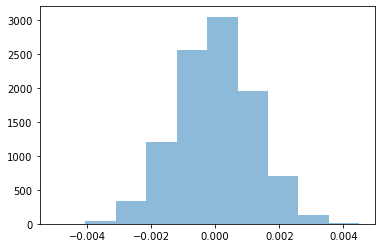

In [34]:
plt.hist(p_diffs, alpha=0.5);

The histogram **shows a normal distribution centered around 0** as expected.

j. Proportion of the **p_diffs** greater than the actual difference observed in **ab_data.csv**

In [35]:
obs_diffs = df2.converted[treatment].mean() - df2.converted[control].mean()
obs_diffs

-0.0015782389853555567

In [36]:
(p_diffs > obs_diffs).mean()

0.9052

k. **Conclusion based on j. above (A/B Testing)**

> In part *j*, I computed the *p-value* = 0.91. This is **not statistically significant**. Therefore, we **fail to reject the null hypothesis**.<br>
> Based on these results, there is *no sufficient evidence to suggest that new landing page converts more users than the old landing page.*

l. Use a built-in to achieve similar results.<br>
In the below:
 - `convert_old` = number of conversions for old page
 - `convert_new` = number of conversions for new page
 - `n_old` = number of rows associated with the old pages
 - `n_new` = number of rows associated with the new pages

In [37]:
convert_old = df2['group'][(df2['group'] == 'control') & (df2['converted'] == 1)].count()
convert_new = df2['group'][(df2['group'] == 'treatment') & (df2['converted'] == 1)].count()
n_old = df2[control]['user_id'].count()
n_new = df2[treatment]['user_id'].count()

m. Use `stats.proportions_ztest` to compute test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [38]:
z_score, p_value = sms.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')
z_score, p_value

(-1.3109241984234394, 0.9050583127590245)

n. Assess the z-score and p-value computed in m. above and discuss what it means for the conversion rates of the old and new pages.  Do they agree with the findings in parts **j.** and **k.**?

**Inteprete z-score and p-value. (in-built method)** <br>
> The negative z-score indicate that the difference observed is lower than mean average by 1.3 standard deviation. This indicates that **the conversion rate is lower on the new page**.<br>
>The p-value is **not statistically significant**, therefore we **fail to reject the null hypothesis**. The p-value means that given that the null hypothesis is true, there is a 90.5% chance that the conversion rates we collected for the new page are greater than or equal to those of the old page. <br>
The p-value found using the in-built method agrees with the findings in parts j and k**.

<a id='regression'></a>
### Part III - A Regression Approach
1. Perform regression on the dataset<br>
a. Type of regression

A **Logistic Regression** should be performed since foe each row, conversion is either yes or no conversion (a categorical variable)

b. Use **statsmodels** to fit the regression model specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.

In [39]:
#Check dataset
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290584 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       290584 non-null  int64 
 1   timestamp     290584 non-null  object
 2   group         290584 non-null  object
 3   landing_page  290584 non-null  object
 4   converted     290584 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 13.3+ MB


In [40]:
#Create column for intercept
#Create dummy variable for landing page (ab_page column = 1 for treatment and 0 for control)
#Double check to confirm
df2['intercept'] = 1
df2[['ab_page', 'old_page']] = pd.get_dummies(df['landing_page'])
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,old_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1


c. Use **statsmodels** to instantiate the regression model on `intercept` and `ab_page` <br>
Fit the model using the two columns to predict whether or not an individual converts. 

In [41]:
log_mod = sms.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sun, 10 Oct 2021   Pseudo R-squ.:               8.077e-06
Time:                        18:11:56   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [42]:
1/np.exp(-0.0150)

1.015113064615719

e. Intepret the p-value associated with **ab_page** in the regression above.

> A p-value of 0.19 is associaetd with ab_pages- this is **not statistically significant**. Therefore, we **fail to reject the null hypothesis**. If an individual landed on the new page, they are 1.015 less likely to be converted than than if they landed on the old page, holding all variables constant.
> Therefore, there is **no sufficient evidence** to recommend the switch to the new page.

f. Other Factors
> One might consider adding other factors to the regression model if it influence the outcome. This can lead to significantly increased predictive capacity. However, care has to be taken to ensure that effect of variables influencing eachother is accounted for - such as multicollinearity etc.

g. Add an effect based on which country a user lives in. Read in the **countries.csv** dataset and merge together datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables

In [43]:
#Read in countries.csv
df_countries = pd.read_csv('countries.csv')
df_countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [44]:
#get the counts and categories of each
df_countries['country'].value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [45]:
#Join both datasets 
df3= df2.join(df_countries.set_index('user_id'), on ='user_id', how ='left' )
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,old_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1,US


In [46]:
#Assess dataset
df3.shape[0]

290584

In [47]:
#Create dummy variables for country
df3[['canada', 'uk', 'us']] = pd.get_dummies(df3['country'])
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,old_page,country,canada,uk,us
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1,US,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,US,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,US,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1,US,0,0,1


In [48]:
#Double check
df3.canada.value_counts()

0    276085
1     14499
Name: canada, dtype: int64

In [49]:
#Double check
df3.uk.value_counts()

0    218118
1     72466
Name: uk, dtype: int64

In [50]:
#Double check
df3.us.value_counts()

1    203619
0     86965
Name: us, dtype: int64

In [51]:
#Fit the logistic regression model
log_mod = sms.Logit(df3['converted'], df3[['intercept', 'ab_page', 'canada', 'uk']])
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Sun, 10 Oct 2021   Pseudo R-squ.:               2.323e-05
Time:                        18:11:57   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
canada        -0.0408      0.027     -1.516      0.130      -0.093       0.012
uk             0.0099      0.013      0.743      0.457      -0.016       0.036
==============================================================================
"""

In [52]:
np.exp(results.params)

intercept    0.136795
ab_page      0.985168
canada       0.960062
uk           1.009932
dtype: float64

In [53]:
1/_

0.00010001000100010001

**Country does not have impact on conversion in my opinion.**

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [54]:
df3['ca_new'] = df3['ab_page']*df3['canada']
df3['uk_new'] = df3['ab_page']*df3['uk']
df3['us_new'] = df3['ab_page']*df3['us']

In [55]:
logit_mod = sms.Logit(df3['converted'], df3[['intercept', 'ab_page', 'canada', 'uk', 'ca_new', 'uk_new', 'us_new']])
results = logit_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290577
Method:                           MLE   Df Model:                            6
Date:                Sun, 10 Oct 2021   Pseudo R-squ.:               3.482e-05
Time:                        18:11:59   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.2847
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9865      0.010   -206.344      0.000      -2.005      -1.968
ab_page       -0.0193   1.53e+05  -1.26e-07      1.000   -2.99e+05    2.99e+05
canada        -0.0175      0.038     -0.465      0.642      -0.091       0.056
uk            -0.0057      0.019     -0.306      0.760      -0.043       0.031
ca_new        -0.0482   1.53e+05  -3.15e-07      1.000   -2.99e+05    2.99e+05
uk_new         0.0301   1.53e+05   1.97e-07      1.000   -2.99e+05    2.99e+05
us_new        -0.0013   1.53e+05  -8.32e-09      1.000   -2.99e+05    2.99e+05
==============================================================================
"""

**Intepretation of Interaction with COuntry of Origin**
>The full model with interactions between page and country, indicates that these interactions has no effects on the predictions based on the p-values which are all *not statistically significant* (>0.05). Therefore, it is best to leave these interactions out of the model both practically and statistically.

<a id='conclusion'></a>
## Conclusion
Based on the results of this analysis, the p-value is **not statistically significant** both in the A/B testing and regression. Therefore, there is **no evidence** to suggest that the new page will lead to more conversion than the old-page. Infact, if an individual landed on the new page, they are 1.015 less likely to be converted than than if they landed on the old page, holding all variables constant. This is also supported by result from the probability rate with a difference of -0.001 between the treatment and control group. Furthermore, there was no evidence of that country affects conversion rate.<br>

**Limitation:** However, I could not run an analysis to assess if the experiment was run long enough to cancel novelty effect and change aversion as date was not included in the dataset. Therefore, I recommend further analysis to determine the duration of the experiments and additional data on type of visitors (new or returning).<br>

Overall, I recommend that the e-commerce company **should run the experiment longer before making a final decision**.